In [1]:
import networkx as nx
from fa2 import ForceAtlas2  #the package should be installed before
import matplotlib.pyplot as plt
from datetime import datetime
from statistics import mean, median, quantiles
from networkx.algorithms.traversal.breadth_first_search import descendants_at_distance
import time
import requests
import glob
import pickle
import pandas as pd
import numpy as np
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import copy

import warnings
warnings.filterwarnings("ignore")

# TRAINING AND VALIDATION OF THE MODELS

In [3]:
def dataframeCreation(allStat, class_num, features):
    stat = {}
    for key in allStat:
        for feature in features:
            if key in stat:
                stat[key].update(allStat[key][feature])
            else:
                stat[key]=allStat[key][feature]
    
    df = pd.DataFrame.from_dict(stat, orient='index')
    df.reset_index(inplace=True, drop=True)
    df["subreddit"] = str(class_num)
    
    return df

In [4]:
def dataframeCreationCommentsNorm(allStat, class_num, features, allFeatures=["authorStats", "timeStats", "commStats"]):
    features_list = []
    for key in allStat:
        for feat in features:
            features_list.extend(list(allStat[key][feat].keys()))
        break
    print(features_list)
    
    stat = {}
    for key in allStat:
        for feature in allFeatures:
            if key in stat:
                stat[key].update(allStat[key][feature])
            else:
                stat[key]=allStat[key][feature]
        
    #print(stat)
    df = pd.DataFrame.from_dict(stat, orient='index')
    df = df[(df["num_comments"] >= 10) & (df["num_comments"] < 30)].reset_index(drop=True)
    df = df[df.columns.intersection(features_list)]
    df["subreddit"] = str(class_num)
    
    return df

In [16]:
def balancing_and_sampling(df1,df2):
    #balancing and sampling data
    num1 = df1.shape[0]
    num2 = df2.shape[0]
    df1_sampled = df1.sample(n=min(num1,num2), random_state=1)
    df2_sampled = df2.sample(n=min(num1,num2), random_state=1)

    df_sampled = pd.concat([df1_sampled,df2_sampled], axis=0).sample(frac=1).reset_index(drop=True)
    df_shuffled = df_sampled.sample(frac=1).reset_index(drop=True)
    
    return df_shuffled

In [13]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [14]:
def train_onData(authorStat_df_sampled, model):
    #dividing into input and output
    input = authorStat_df_sampled.drop(columns=['subreddit'])
    output = authorStat_df_sampled['subreddit']
    
    #dividing into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(input, output, train_size=0.95, test_size=0.05, random_state=1)
    y_train=y_train.astype('int')
    y_test=y_test.astype('int')
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': [True]}
    pprint(random_grid)
    
    
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier(oob_score=True)
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 200, cv = 6, verbose=5, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(x_train, y_train)
    
    pprint(rf_random.best_params_)
    
    base_model = RandomForestClassifier(n_estimators = 10, random_state = 42, oob_score=True, bootstrap=True)
    base_model.fit(x_train, y_train)
    #base_accuracy = evaluate(base_model, x_test, y_test)
    print("Accuracy base model: ",base_model.oob_score_)
    
    best_random = rf_random.best_estimator_
    #random_accuracy = evaluate(best_random, x_test, y_test)
    print("Accuracy random model: ",best_random.oob_score_)
    
    # save
    joblib.dump(rf_random, "./"+model+".joblib")
    
    
    # Get numerical feature importances
    importances = list(best_random.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x_test.columns, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:25} Importance: {}'.format(*pair)) for pair in feature_importances];
    
    sorted_idx = best_random.feature_importances_.argsort()
    plt.barh(x_test.columns[sorted_idx],best_random.feature_importances_[sorted_idx])

In [8]:
#subfolder = "total"
subfolder = "distrEqualized"

with open('stat_puppies_'+subfolder+'.pickle', 'rb') as handle:
    allStat_puppies = pickle.load(handle)

with open('stat_PoliticalDiscussion_'+subfolder+'.pickle', 'rb') as handle:
    allStat_PoliticalDiscussion = pickle.load(handle)

In [33]:
df1 = dataframeCreationCommentsNorm(copy.deepcopy(allStat_puppies), 1, ["commStats"]) #'timeStats', 'commStats'
df2 = dataframeCreationCommentsNorm(copy.deepcopy(allStat_PoliticalDiscussion), 2, ["commStats"]) #'timeStats', 'commStats'

['num_comments', 'num_direct_comments', 'max_depth', 'H_index']
['num_comments', 'num_direct_comments', 'max_depth', 'H_index']


In [18]:
#df1 = df1[(df1["num_comments"] >= 10) & (df1["num_comments"] < 30)].reset_index(drop=True)
#df2 = df2[(df2["num_comments"] >= 10) & (df2["num_comments"] < 30)].reset_index(drop=True)

In [36]:
df = balancing_and_sampling(df1, df2)

In [ ]:
#train_onData(df, "model_commStats")
#train_onData(df, "model_commStats_Comms_1029")
#train_onData(df, "model_commStats_commEqualized")
train_onData(df, "model_commStats_1029Equalized")

In [38]:
df1 = dataframeCreationCommentsNorm(copy.deepcopy(allStat_puppies), 1, ["authorStats"]) #'timeStats', 'commStats'
df2 = dataframeCreationCommentsNorm(copy.deepcopy(allStat_PoliticalDiscussion), 2, ["authorStats"]) #'timeStats', 'commStats'

#df1 = df1[(df1["num_comments"] >= 10) & (df1["num_comments"] < 30)].reset_index(drop=True)
#df2 = df2[(df2["num_comments"] >= 10) & (df2["num_comments"] < 30)].reset_index(drop=True)

['num_users', 'num_edges', 'size_largest_conn_comp', 'recip_value', 'diam', 'clust_coeff']
['num_users', 'num_edges', 'size_largest_conn_comp', 'recip_value', 'diam', 'clust_coeff']


In [39]:
df = balancing_and_sampling(df1, df2)

In [ ]:
#train_onData(df, "model_authorStats")
#train_onData(df, "model_authorStats_Comms_1029")
train_onData(df, "model_authorStats_1029Equalized")

In [41]:
df1 = dataframeCreationCommentsNorm(copy.deepcopy(allStat_puppies), 1, ["timeStats"]) #'timeStats', 'commStats'
df2 = dataframeCreationCommentsNorm(copy.deepcopy(allStat_PoliticalDiscussion), 2, ["timeStats"]) #'timeStats', 'commStats'

#df1 = df1[(df1["num_comments"] >= 10) & (df1["num_comments"] < 30)].reset_index(drop=True)
#df2 = df2[(df2["num_comments"] >= 10) & (df2["num_comments"] < 30)].reset_index(drop=True)

['lifeTime', 'averageTime', 'medianTime', 'lifetime95']
['lifeTime', 'averageTime', 'medianTime', 'lifetime95']


In [42]:
df = balancing_and_sampling(df1, df2)

In [ ]:
train_onData(df, "model_timeStats_1029Equalized")

In [44]:
df1 = dataframeCreationCommentsNorm(copy.deepcopy(allStat_puppies), 1, ["authorStats", "timeStats", "commStats"]) #'timeStats', 'commStats'
df2 = dataframeCreationCommentsNorm(copy.deepcopy(allStat_PoliticalDiscussion), 2, ["authorStats", "timeStats", "commStats"]) #'timeStats', 'commStats'

#df1 = df1[(df1["num_comments"] >= 10) & (df1["num_comments"] < 30)].reset_index(drop=True)
#df2 = df2[(df2["num_comments"] >= 10) & (df2["num_comments"] < 30)].reset_index(drop=True)

['num_users', 'num_edges', 'size_largest_conn_comp', 'recip_value', 'diam', 'clust_coeff', 'lifeTime', 'averageTime', 'medianTime', 'lifetime95', 'num_comments', 'num_direct_comments', 'max_depth', 'H_index']
['num_users', 'num_edges', 'size_largest_conn_comp', 'recip_value', 'diam', 'clust_coeff', 'lifeTime', 'averageTime', 'medianTime', 'lifetime95', 'num_comments', 'num_direct_comments', 'max_depth', 'H_index']


In [45]:
df = balancing_and_sampling(df1, df2)

In [ ]:
train_onData(df, "model_allStats_1029Equalized")

# VISUALIZATION OF THE RESULTS

In [19]:
def plot_info_sing(rf_1, title_1):
    
    
    best_random_1 = rf_1.best_estimator_
    print("Accuracy of the model: ",best_random_1.oob_score_)
    fig, ax = plt.subplots(figsize=(20,8))
    #fig.suptitle('Importances of the features')
    
    sorted_idx_1 = list(reversed(best_random_1.feature_importances_.argsort()))
    
    N = len(sorted_idx_1)
    #width = 0.35
    ind = np.arange(N)  # the x locations for the groups
    
    rects1 = ax.bar(ind, best_random_1.feature_importances_[sorted_idx_1])#, width=width)
    
    # new helper method to auto-label bars
    #ax1.bar_label(ax1.containers[0])
    #ax2.bar_label(ax2.containers[0])
    
    #ax1.set_title(title_1)
    #ax2.set_title(title_2)
    
    # add some text for labels, title and axes ticks
    ax.set_ylabel('Importance')
    ax.set_title('Importances of the features')
    ax.set_xticks(ind)# + width / 2)
    ax.set_xticklabels(best_random_1.feature_names_in_[sorted_idx_1], rotation=45)
    
    ax.legend('features')


    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    round(float(height), 3),
                    ha='center', va='bottom')

    autolabel(rects1)
    plt.show()

In [20]:
def print_info_sing(rf, title):
    best_random = rf.best_estimator_
    print()
    print()
    print("\t",title.upper())
    print()
    print("Accuracy of the model: ",best_random.oob_score_)
    
    # Get numerical feature importances
    importances = list(best_random.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(best_random.feature_names_in_, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    #[print('Variable: {:25} Importance: {}'.format(*pair)) for pair in feature_importances];

    sorted_idx = best_random.feature_importances_.argsort()
    plt.barh(best_random.feature_names_in_[sorted_idx],best_random.feature_importances_[sorted_idx])
    plt.title(title)
    plt.show()

In [17]:
#"model_commStats_base"            "./model_*_base*"
#"model_commStats_Comms_1029"      "./model_*_Comms*"
#"model_commStats_commEqualized"   "./model_*_commEqualized*"
#"model_commStats_1029Equalized"   "./model_*_1029E*"
models = sorted(glob.glob("./model_*_1029E*"))
print(models)

['./model_allStats_1029Equalized.joblib', './model_authorStats_1029Equalized.joblib', './model_commStats_1029Equalized.joblib', './model_timeStats_1029Equalized.joblib']


Accuracy of the model:  0.8871866295264624


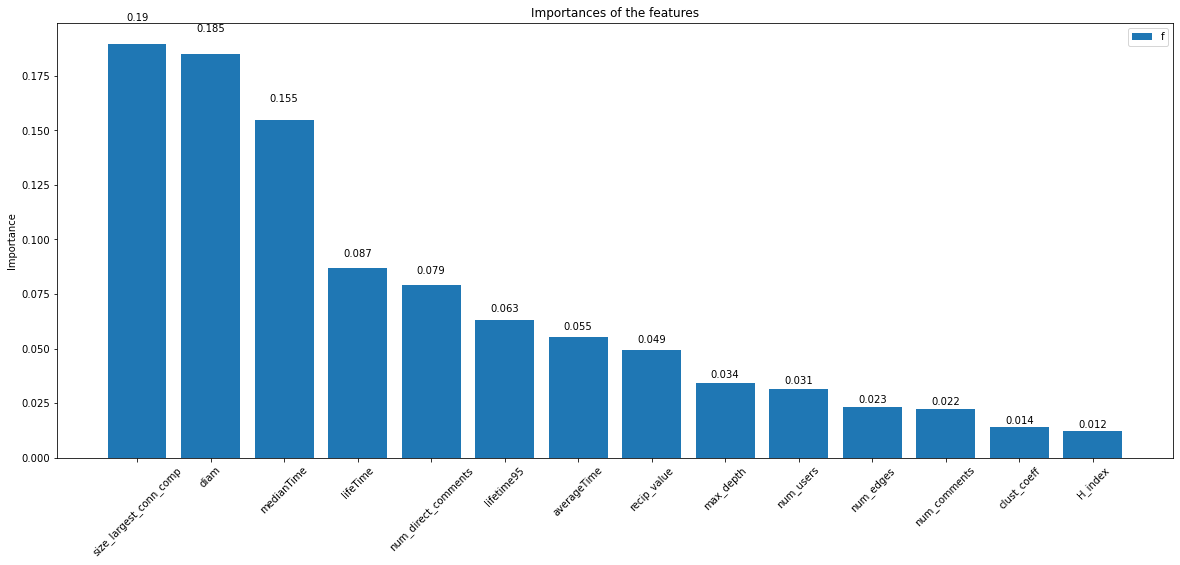

Accuracy of the model:  0.8147632311977716


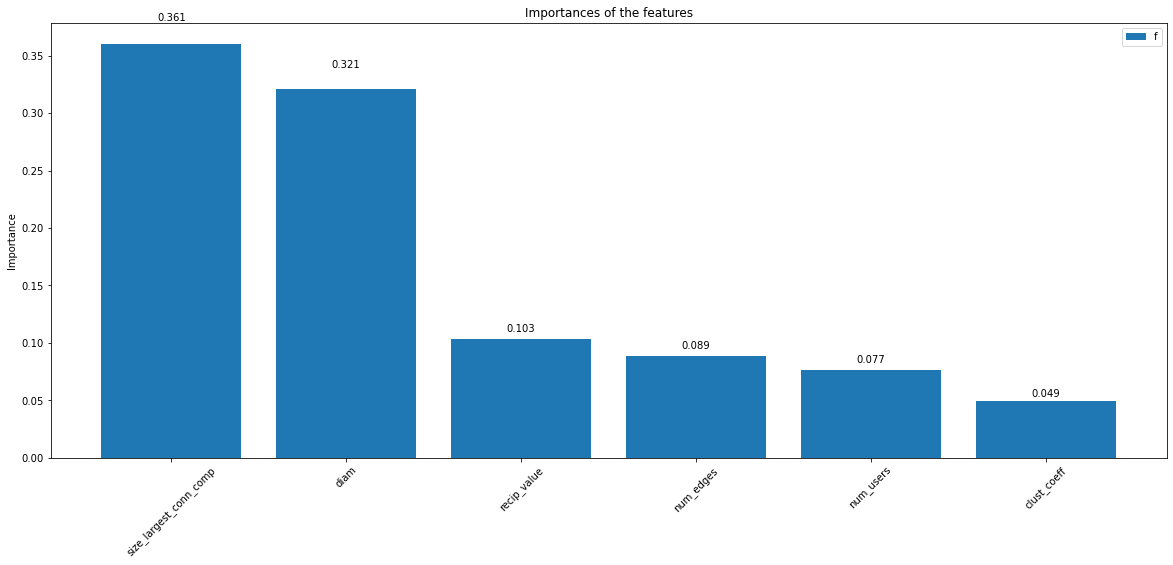

Accuracy of the model:  0.6810584958217271


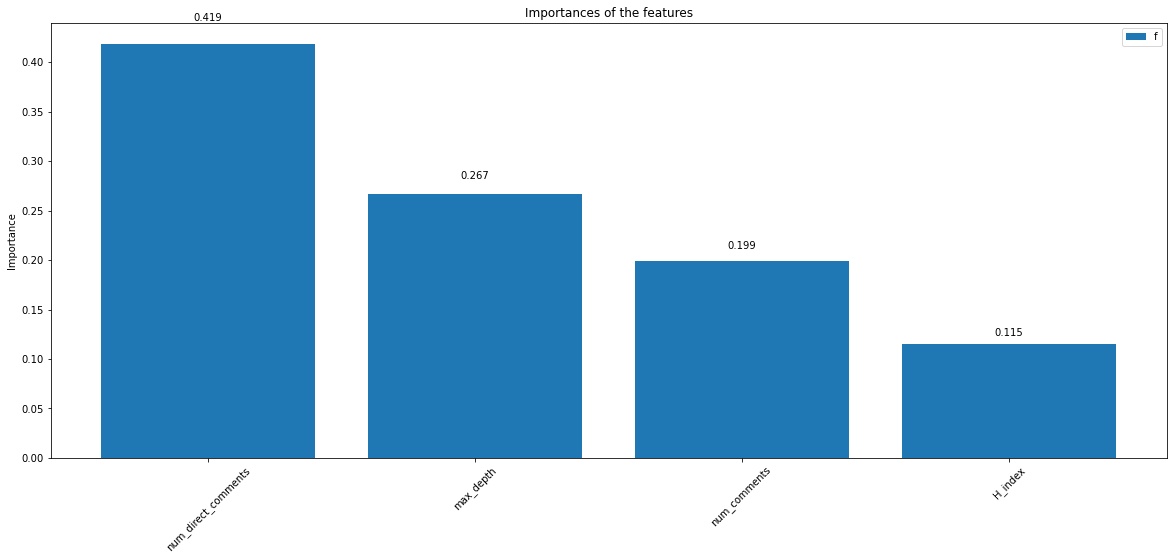

Accuracy of the model:  0.786908077994429


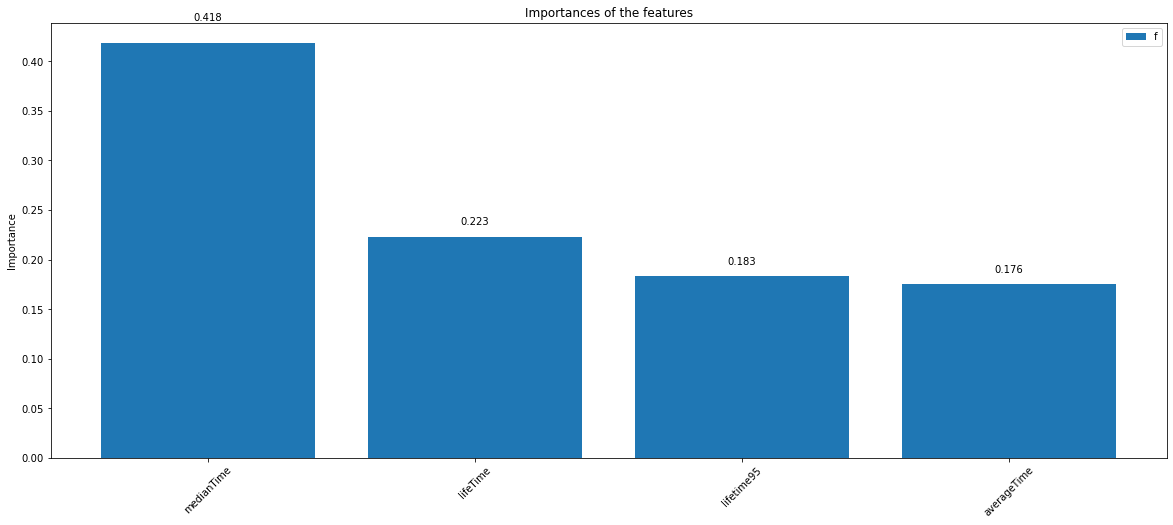

In [21]:
num = 0
while num < len(models):
    rf_1 = joblib.load(models[num])
    title_1 = '_'.join([str(elem) for elem in models[num].split("_")[1:]]).split(".")[0]
    plot_info_sing(rf_1, title_1)
    num+=1